## IST 718 Lab 2
### Bing-Je Wu

The research question is can we predict which three zip codes provide the best investment opportunity for the Syracuse Real Estate Investment Trust (SREIT)?

* Using the base data available from Zillow   
    + (http://files.zillowstatic.com/research/public/Zip/Zip_Zhvi_SingleFamilyResidence.csv)  
    + Review the data – clean as appropriate
    + Provide an initial data analysis to include (but not limited to):
        + Develop time series plots for the following Arkansas metro areas:
            - Hot Springs, Little Rock, Fayetteville, Searcy
            - Present all values from 1997 to present
            - Average at the metro area level
        
* Using data from Zillow:
    + Develop model(s) for forecasting average median housing value by zip code for 2018
    + Use the historical data from 1997 through 2017 as your training data
    + Integrate data from other sources (think Bureau of Labor Statistics and Census data) to improve upon your base model(s)
    
+ Answer the following questions:
    + What technique/algorithm/decision process did you use to down sample? (BONUS FOR NOT DOWN SAMPLING)
    + What three zip codes provide the best investment opportunity for the SREIT? 
    + Why?
    
+ Bonus: Develop a geographic visualization that in your view best depicts the data and recommendations:
    + Bystate 
    + MedianhousingforDec(stateaverage)

Glossary:   
Zillow Home Value Index (ZHVI): A smoothed, seasonally adjusted measure of the typical home value and market changes across a given region and housing type. Zillow publishes top-tier ZHVI ($, typical value for homes within the 65th to 95th percentile range for a given region) and bottom-tier ZHVI ($, typical value for homes that fall within the 5th to 35th percentile range for a given region). Zillow also publishes ZHVI for all single-family residences ($, typical value for all single-family homes in a given region), for condo/coops ($), for all homes with 1, 2, 3, 4 and 5+ bedrooms ($), and the median ZHVI per square foot ($, typical value of all homes per square foot calculated by taking the estimated home value for each home in a given region and dividing it by the home’s square footage).

Datasets:
 1. SingleFamilyResidence
 http://files.zillowstatic.com/research/public/Zip/Zip_Zhvi_SingleFamilyResidence.csv
 2. Labor Force Data by County, 2018 Annual Averages
https://www.bls.gov/lau/laucnty18.txt ; https://www.bls.gov/lau/laucnty18.xlsx

* Outline:
    + Load the dataset
    + Explore the datasets
        - SingleFamilyResidence dataset
        - laucnty18 dataset
        - merge datasets (left join)
    * Statistics Analysis
    * Models
        + The Naive Model - Baseline Model
        + ARIMA Model - part 1 (General Time Series)
        + ARIMA Model - part 2 (Time Series for each zip code)
    * Final Model
    * Questions
    * Conclusion

# Load the dataset

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy.stats
import pylab

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima_model import ARIMA 
import itertools
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 300)

In [2]:
df=pd.read_csv('http://files.zillowstatic.com/research/public/Zip/Zip_Zhvi_SingleFamilyResidence.csv', encoding='latin-1')
df.head(10)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12
0,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1483368,1468482,1461572,1454050,1454111,1451781,1449835,1450723,1440314,1433973,1429073,1428637,1425987,1407384,1391270,1380332,1386270,1394397,1404225,1406599,1399918,1380178,1358401,1350481,1345845
1,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,355664.0,354736.0,355404.0,355863.0,357309.0,359906.0,362935.0,366493.0,369236.0,371964.0,374364.0,376322.0,377455.0,380637.0,381917.0,384322.0,383195.0,381889.0,...,932154,941705,953981,959260,960954,959673,959082,954912,950660,948543,948906,951721,954743,957441,961651,966123,967557,965155,960225,956709,953095,950684,948136,946838,945928
2,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1543592,1531018,1537936,1551681,1568820,1573613,1578249,1582848,1583553,1580068,1573052,1563902,1550264,1531141,1521399,1520816,1526676,1525174,1516721,1504180,1492086,1480934,1468075,1454870,1438313
3,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,197907.0,196854.0,195911.0,197300.0,197320.0,198443.0,197736.0,198462.0,199158.0,200824.0,201754.0,202558.0,205017.0,207485.0,208972.0,209013.0,211437.0,215407.0,...,330287,331699,332214,332264,332737,333805,334293,333806,333609,333839,334129,334753,334497,335272,335363,335789,335035,334542,334176,334363,334127,334458,334460,334679,334309
4,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,5,537402.0,536919.0,539044.0,540137.0,542594.0,546190.0,550015.0,554436.0,557214.0,560140.0,562389.0,565003.0,566844.0,574208.0,578552.0,583864.0,582314.0,581470.0,...,1176623,1186741,1197817,1201566,1204015,1204371,1201598,1195307,1189358,1186838,1185950,1187917,1190385,1191138,1193324,1198898,1203423,1204840,1199747,1194591,1188702,1183500,1179024,1175407,1174008
5,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,6,97337.0,97145.0,96967.0,96645.0,96671.0,96805.0,97006.0,97094.0,97121.0,97093.0,97026.0,96942.0,96947.0,96877.0,96986.0,96941.0,96960.0,96983.0,...,172450,172949,173412,174031,175131,176228,177072,177465,178115,178774,179453,179904,180418,181290,181995,182559,182569,182940,183549,184481,185254,185518,186051,187010,187930
6,61616,10002,New York,NY,New York-Newark-Jersey City,New York County,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1335982,1338561,1348937,1351916,1358788,1363132,1369718,1376232,1371455,1369384,1366151,1363616,1362378,1360228,1366145,1367339,1360449,1351086,1338922,1331149,1321363,1317405,1302224,1287120,1273889
7,91733,77084,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,8,97318.0,97177.0,97052.0,96719.0,96609.0,96603.0,96824.0,96832.0,96713.0,96538.0,96322.0,96214.0,96034.0,95907.0,95813.0,95755.0,95756.0,95770.0,...,168958,169280,169682,170375,171702,173079,174161,174860,175710,176572,177375,177998,178631,179539,180236,180757,180839,181191,181836,182590,183239,183408,184045,184837,185617
8,93144,79936,El Paso,TX,El Paso,El Paso County,9,82436.0,82406.0,82350.0,82301.0,82242.0,82277.0,82423.0,82613.0,82831.0,82999.0,83088.0,83158.0,83217.0,83132.0,82969.0,82727.0,82648.0,82707.0,...,123616,123633,123678,123540,123349,123401,124135,125006,125695,126188,126632,127242,127718,128286,128995,129970,131037,132217,133250,133920,134372,133690,132794,132286,132730
9,84640,60640,Chicago,IL,Chicago-Naperville-Elgin,Cook County,10,244560.0,244663.0,246601.0,248032.0,250914.0,252956.0,255357.0,255486.0,25

In [0]:
df_labor2018 = pd.read_excel('https://www.bls.gov/lau/laucnty18.xlsx', header=4)
df_labor = df_labor2018.iloc[1:3219,:].copy()
df_labor.reset_index(inplace=True)
df_labor.dropna(axis=1, inplace=True)

# Explore the datasets
##### SingleFamilyResidence dataset

In [4]:
print((df.loc[:,'1997-01':'1997-12'].isna()).sum())

1997-01    16518
1997-02    16469
1997-03    16411
1997-04    16360
1997-05    16330
1997-06    16309
1997-07    16290
1997-08    16244
1997-09    16195
1997-10    16153
1997-11    16103
1997-12    16084
dtype: int64


There are at least 16084 records do not have data during the year of 1997.   
In order to do the analysis from 1997 to present, it would be better to drop those rows to get the insightful data and to convert it into a time series data. 

In [5]:
df_1997 = df[pd.notnull(df['1997-01'])].copy()
# check na values after 1997
df_1997.loc[:,'1997-01':'1997-12'].isna().sum()

1997-01    0
1997-02    0
1997-03    0
1997-04    0
1997-05    0
1997-06    0
1997-07    0
1997-08    0
1997-09    0
1997-10    0
1997-11    0
1997-12    0
dtype: int64

28 counties has problems:  
anchorage borough AK-> anchorage borough/municipality AK 69  
de kalb county AL-> dekalb county AL 24  
saint francis county AR-> st. francis county AR 172  
san francisco county CA-> san francisco county/city  CA 223  
broomfield county CO-> broomfield county/city CO 251  
denver county CO-> denver county/city  CO 260  
district of columbia DC-> district of columbia None 319  
de soto county FL-> desoto county  FL 332  
saint johns county FL-> st. johns county  FL 374  
saint lucie county FL-> st. lucie county  FL 375  
honolulu county HI-> honolulu county/city HI 547  
dewitt county IL-> de witt county  IL 613  
la salle county IL-> lasalle county IL 643  
de kalb county IN-> dekalb county  IN 712  
saint bernard parish LA-> st. bernard parish LA 1155  
saint charles parish LA-> st. charles parish LA 1156  
queen annes county MD-> queen anne's county MD 1208  
saint marys county MD-> st. mary's county MD 1209  
prince georges county MD-> prince george's county MD 1207  
saint clair county MI-> st. clair county   MI 1303  
saint joseph county MI-> st. joseph county MI 1304  
saint francois county MO-> st. francois county  MO 1576  
saint charles county MO-> st. charles county MO 1573  
saint louis city MO-> st. louis city MO 1596  
saint louis county MO-> st. louis county  MO 1577  
saint lawrence county NY-> st. lawrence county NY 1871  
leflore county OK-> le flore county OK 2169  
philadelphia county PA-> philadelphia county/city PA 2293  
1. saint -> st.
2. "'" -> ''
3. county/city -> county
4. borough/municipality -> borough

In [0]:
def normalize_str(strings):
    """
    Expect: string contain uppercase and lowercase, "'" sign, '/city', 'Saint', '/municipality'
    Modifies: convert upper to lower, strip leading or trailing spaces, remove unwanted string, change 'saint' to 'st.'
    Returns: lowercasestring
    """
    temp=strings.lower()
    if "'" in temp:
        temp=temp.replace("'",'')
    if '/city' in temp:
        temp=temp.replace('/city','')
    if 'saint' in temp:
        temp=temp.replace('saint','st.')
    if '/municipality' in temp:
        temp=temp.replace('/municipality','')
    result=temp.strip()
    return result

In [7]:
df_1997['CountyName']=df_1997['CountyName'].apply(normalize_str)
print('String normalization has been completed')

String normalization has been completed


In [8]:
df_1997.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12
1,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,cook county,2,355664.0,354736.0,355404.0,355863.0,357309.0,359906.0,362935.0,366493.0,369236.0,371964.0,374364.0,376322.0,377455.0,380637.0,381917.0,384322.0,383195.0,381889.0,...,932154,941705,953981,959260,960954,959673,959082,954912,950660,948543,948906,951721,954743,957441,961651,966123,967557,965155,960225,956709,953095,950684,948136,946838,945928
3,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,harris county,4,197907.0,196854.0,195911.0,197300.0,197320.0,198443.0,197736.0,198462.0,199158.0,200824.0,201754.0,202558.0,205017.0,207485.0,208972.0,209013.0,211437.0,215407.0,...,330287,331699,332214,332264,332737,333805,334293,333806,333609,333839,334129,334753,334497,335272,335363,335789,335035,334542,334176,334363,334127,334458,334460,334679,334309
4,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,cook county,5,537402.0,536919.0,539044.0,540137.0,542594.0,546190.0,550015.0,554436.0,557214.0,560140.0,562389.0,565003.0,566844.0,574208.0,578552.0,583864.0,582314.0,581470.0,...,1176623,1186741,1197817,1201566,1204015,1204371,1201598,1195307,1189358,1186838,1185950,1187917,1190385,1191138,1193324,1198898,1203423,1204840,1199747,1194591,1188702,1183500,1179024,1175407,1174008
5,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,harris county,6,97337.0,97145.0,96967.0,96645.0,96671.0,96805.0,97006.0,97094.0,97121.0,97093.0,97026.0,96942.0,96947.0,96877.0,96986.0,96941.0,96960.0,96983.0,...,172450,172949,173412,174031,175131,176228,177072,177465,178115,178774,179453,179904,180418,181290,181995,182559,182569,182940,183549,184481,185254,185518,186051,187010,187930
7,91733,77084,Houston,TX,Houston-The Woodlands-Sugar Land,harris county,8,97318.0,97177.0,97052.0,96719.0,96609.0,96603.0,96824.0,96832.0,96713.0,96538.0,96322.0,96214.0,96034.0,95907.0,95813.0,95755.0,95756.0,95770.0,...,168958,169280,169682,170375,171702,173079,174161,174860,175710,176572,177375,177998,178631,179539,180236,180757,180839,181191,181836,182590,183239,183408,184045,184837,185617


Some 'RegionName(Zipcode)' column are stating with zeros. Thus, when pandas imported the data, the 'RegionName(Zipcode)' column has been imported as numeric, and the zipcode information are lost.  
We need to convert 'RegionName(Zipcode)' column back to string type and tap the 0s for those 'RegionName(Zipcode)' with leading 0s.


In [0]:
df_1997=df_1997.astype({'RegionName':str}) 

In [0]:
def normalize_zipcode(strings):
    """
    Expect: strings less than 5 characters, ex: "123"
    Modifies: pad 0 before the strings
    Returns: a string with lenght of 5
    """
    # if length of strings is 5; remain the samne
    if len(strings) == 5:
        return strings
    # if length of strings less than 5; pad 0s to the left
    elif len(strings) < 5:
        result = strings.zfill(5)
        return result

In [11]:
df_1997['RegionName']=df_1997['RegionName'].apply(normalize_zipcode)
print('Zipcode normalization has been completed')

Zipcode normalization has been completed


##### laucnty18 dataset

In [12]:
df_labor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3218 entries, 0 to 3217
Data columns (total 10 columns):
index                             3218 non-null int64
Code                              3218 non-null object
Code.1                            3218 non-null float64
Code.2                            3218 non-null float64
County Name/State Abbreviation    3218 non-null object
Year                              3218 non-null float64
Force                             3218 non-null float64
Employed                          3218 non-null float64
Unemployed                        3218 non-null float64
(%)                               3218 non-null float64
dtypes: float64(7), int64(1), object(2)
memory usage: 251.5+ KB


In [13]:
df_labor.head()

,index,Code,Code.1,Code.2,County Name/State Abbreviation,Year,Force,Employed,Unemployed,(%)
0,1,CN0100100000000,1.0,1.0,"Autauga County, AL",2018.0,25957.0,25015.0,942.0,3.6
1,2,CN0100300000000,1.0,3.0,"Baldwin County, AL",2018.0,93849.0,90456.0,3393.0,3.6
2,3,CN0100500000000,1.0,5.0,"Barbour County, AL",2018.0,8373.0,7940.0,433.0,5.2
3,4,CN0100700000000,1.0,7.0,"Bibb County, AL",2018.0,8661.0,8317.0,344.0,4.0
4,5,CN0100900000000,1.0,9.0,"Blount County, AL",2018.0,25006.0,24128.0,878.0,3.5


To combine the **laucnty18** dataset and **SingleFamilyResidence** dataset, first we need to do some cleaning on **laucnty18** dataset.  
Because the **laucnty18** dataset is built based on county, thus, the '*County Name/State Abbreviation*' column needs to be splited into '*County*' and '*State*'.  
And create a new dataframe, **df_unemployed_rate**,  contains '*County Name*', '*State Abbreviation*', '*Rate*'.

In [0]:
# Define a split_2 function to split county name and state abbreviation
def split_2(cell_str):
    """
    Expect: a string such as 'Autauga County, AL'
    Modifies: split the string on ', '
    Returns: a list
    """
    # strip the leading or trailing spaces, then split
    result = cell_str.strip().split(', ')
    return result

In [15]:
df_labor['County Name/State Abbreviation_list'] = df_labor['County Name/State Abbreviation'].map(split_2)
df_CNT_ST= pd.DataFrame(df_labor['County Name/State Abbreviation_list'].values.tolist(), 
             columns=['County Name','State Abbreviation'])
print('String spliting has been completed')

String spliting has been completed


In [16]:
# Normalize the 'County Name'
df_CNT_ST['County Name'] = df_CNT_ST['County Name'].apply(normalize_str)
print('String normalization has been completed')

String normalization has been completed


7 counties still has problems and need to be revised mannually:    
   [df_1997]     ->              [df_CNT_ST]   
de kalb county AL-> dekalb county AL 24  
district of columbia DC-> district of columbia None 319  
de soto county FL-> desoto county  FL 332  
dewitt county IL-> de witt county  IL 613  
la salle county IL-> lasalle county IL 643  
de kalb county IN-> dekalb county  IN 712  
leflore county OK-> le flore county OK 2169  

In [17]:
# assign new county name and state information to match the main dataset, df_1997
df_CNT_ST.loc[[24,332,613,643,712,2169],'County Name'] = ['de kalb county', 'de soto county', 'dewitt county', 
                                                          'la salle county', 'de kalb county', 'leflore county']
df_CNT_ST.loc[[319],'State Abbreviation']='DC'
print('Mannual revision has been completed')

Mannual revision has been completed


In [0]:
df_unemployed_rate = pd.concat( [df_CNT_ST, df_labor[['(%)']] ], axis=1)
df_unemployed_rate.rename(columns={'(%)': 'Rate'}, inplace=True)

In [19]:
df_unemployed_rate.head()

,County Name,State Abbreviation,Rate
0,autauga county,AL,3.6
1,baldwin county,AL,3.6
2,barbour county,AL,5.2
3,bibb county,AL,4.0
4,blount county,AL,3.5


##### merge datasets

In [20]:
# df_1997 has 13916 records and merged_left should have 13916 records after merging
merged_left = pd.merge(left=df_1997,right=df_unemployed_rate, 
                         left_on=['CountyName','State'], 
                         right_on=['County Name','State Abbreviation'],
                         how='left')

# What's the size of the output data?
merged_left.shape

(13916, 295)

In [21]:
# Check if there is numatch record
merged_left[merged_left['Rate'].isnull()].groupby(['State', 'Metro', 'CountyName']).count()

,,,RegionID,RegionName,City,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,...,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,County Name,State Abbreviation,Rate
State,Metro,CountyName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [22]:
# The average unemployment rate
merged_left['Rate'].mean()

3.9796032772747663

In [23]:
df.shape

(30434, 292)

Here, the merged_left is the complete dataset that we are going to use to build arima models and answer the research questions.  
The merged_left dataframe combined the unemployment rate.  
Higher unemployment rate imples lower ability to purchase a house, lower demand in the market. Thus, the unemployment rate can be a crucial indicator when making a decision on real estate investment. Based on this concept, we set the standard unemployment rate as 3.98 (the average of the 13,916 zipcodes).  
To be considered as a valuable zipcode for real estate investment, we want to exclude the zipcodes that have the unemployment rate higher than average (include the zipcodes that have the unemployment rate less than 3.98)

In [24]:
df_invest = merged_left[merged_left.Rate < 3.98].copy()
df_invest.reset_index(inplace=True)
#df_invest=df_invest.astype({'RegionName':str}) 
df_invest.shape

(7425, 296)

##### General Time Series as benchmark

Now we have **7,425** candidate zipcodes.  We are going to use those 7,425 zipcodes to perform time series analysis.  
To perform the time series analysis, we need to convert the dataframe into time series format. 

In [0]:
df_invest=df_invest.loc[:,'RegionName':'2018-12']
df_invest.drop(columns=['City','State','Metro','CountyName', 'SizeRank','1996-04','1996-05','1996-06','1996-07','1996-08','1996-09','1996-10','1996-11','1996-12'], inplace=True)
df_invest.rename(columns={'RegionName':'Zipcode'}, inplace=True)

In [0]:
df_gen_ts = pd.DataFrame(df_invest.loc[:,'1997-01':'2018-12'].mean(), columns=['Price'])
df_gen_ts.index=pd.to_datetime(df_gen_ts.index)

In [27]:
df_gen_ts.head()

,Price
1997-01-01,151565.318788
1997-02-01,152001.501145
1997-03-01,152379.858451
1997-04-01,152665.096027
1997-05-01,153034.888620


##### Time Series for each zipcode

In [28]:
df_invest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7425 entries, 0 to 7424
Columns: 265 entries, Zipcode to 2018-12
dtypes: float64(250), int64(14), object(1)
memory usage: 15.0+ MB


First, we creat a 78660 time series

In [29]:
df_invest[(df_invest['Zipcode']=='78660')]

,Zipcode,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,...,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
0,78660,144458.0,144797.0,145170.0,145316.0,145389.0,145445.0,145588.0,145689.0,145821.0,145978.0,146191.0,146371.0,146277.0,146044.0,145704.0,145300.0,145029.0,144934.0,145241.0,145479.0,145716.0,145689.0,145843.0,145880.0,...,239450.0,239891.0,240474.0,241438.0,243076.0,243922.0,244236.0,243969.0,244474.0,245435.0,246815.0,247853,248919,249992,250615,250950,251197,252087,253609,254881,256225,256222,256778,256546,257494


In [30]:
temp_df = df_invest[(df_invest['Zipcode']=='78660')].copy()
temp_df = temp_df.iloc[:,1:]
df_ts = temp_df.T.rename(columns={0:'78660'})
df_ts.index=pd.to_datetime(df_ts.index)

# How many row do we have ? 
# Supposely it should be 265-1 =264
df_ts.shape

(264, 1)

Now, we can create a tuple to iterate the rest of zipcodes anc concatenate it with the df_ts dataframe.

In [31]:
# create a zipcode tuple
zip_tuple = tuple(df_invest.Zipcode.values[1:]) # remove the first zipcode, 78660, in the tuple

# How many zipcode?
len(zip_tuple)

7424

In [32]:
for i, z in enumerate(zip_tuple, start=1):
    temp_df = df_invest[(df_invest['Zipcode']==z)].copy()
    temp_df = temp_df.iloc[:,1:]
    temp_df_ts = temp_df.T.rename(columns={i:z})
    df_ts = pd.concat([df_ts,temp_df_ts], axis=1)

# How many row do we have ? 
# Supposely it should be 264 row (months) and 7,425 columns (zipcodes)
df_ts.shape

(264, 7425)

In [0]:
#df_ts.to_csv('df_zipcode_ts.csv') 

In [34]:
df_ts.head()

,78660,94109,37013,11375,37211,28269,78613,75052,37042,73099,78245,30044,63376,28277,30043,10463,30096,07030,98052,30024,75287,78666,33160,23464,34787,...,02836,43505,80425,46067,53101,38070,55029,24570,95724,68531,43007,74117,20629,80479,14520,43047,49311,95141,81225,21405,45816,47986,55144,04033,02872
1997-01-01,144458.0,556765.0,118640.0,287468.0,117549.0,137052.0,161292.0,99438.0,90677.0,85101.0,100899.0,120159.0,113522.0,206086.0,147396.0,302560.0,136369.0,306111.0,246173.0,194490.0,181037.0,91746.0,303643.0,115818.0,150088.0,...,132048.0,63530.0,143769.0,54558.0,172202.0,34857.0,85012.0,151906.0,228040.0,204859.0,87398.0,60806.0,183575.0,153175.0,73081.0,50853.0,147767.0,530192.0,311597.0,405354.0,78286.0,56932.0,60352.0,346670.0,140299.0
1997-02-01,144797.0,564078.0,119233.0,290379.0,118195.0,137822.0,161121.0,99708.0,90733.0,85193.0,100866.0,120439.0,113887.0,207180.0,147856.0,304375.0,136874.0,307698.0,247444.0,195068.0,182088.0,91950.0,305611.0,116103.0,149820.0,...,130436.0,63060.0,143526.0,54794.0,173373.0,35267.0,85411.0,151992.0,231260.0,206854.0,88745.0,60843.0,183289.0,153870.0,73398.0,51243.0,150182.0,533211.0,312970.0,405121.0,77711.0,56766.0,60820.0,350783.0,139934.0
1997-03-01,145170.0,568911.0,119739.0,292974.0,118866.0,138460.0,161016.0,99789.0,90908.0,85253.0,100986.0,120488.0,114205.0,207919.0,148007.0,307259.0,137039.0,309878.0,248902.0,195204.0,182737.0,92210.0,307517.0,116214.0,150581.0,...,129807.0,62088.0,142773.0,54541.0,174780.0,35395.0,84409.0,151527.0,232886.0,207702.0,89631.0,59999.0,182923.0,155616.0,73263.0,51105.0,150707.0,535826.0,314857.0,403622.0,77806.0,56077.0,60921.0,346681.0,140071.0
1997-04-01,145316.0,563733.0,120066.0,295684.0,119390.0,138771.0,160779.0,99848.0,91320.0,85435.0,101058.0,120512.0,114861.0,208418.0,148107.0,309002.0,137181.0,311231.0,250493.0,195078.0,184020.0,92381.0,308598.0,116219.0,151312.0,...,129297.0,61231.0,143530.0,54814.0,174499.0,35158.0,84335.0,150090.0,233418.0,210010.0,91058.0,59602.0,181093.0,156517.0,73429.0,50724.0,150969.0,534342.0,316447.0,400744.0,78895.0,55657.0,61143.0,345354.0,139852.0
1997-05-01,145389.0,567592.0,120300.0,297026.0,119862.0,138917.0,160626.0,99872.0,91561.0,85794.0,101213.0,120597.0,115586.0,208984.0,148122.0,309176.0,137233.0,312665.0,253169.0,195161.0,184134.0,92450.0,309149.0,116399.0,152096.0,...,128670.0,61343.0,145448.0,55781.0,175184.0,35276.0,83503.0,150693.0,233266.0,210514.0,91627.0,59640.0,180081.0,156449.0,73586.0,50616.0,150943.0,538771.0,317761.0,401395.0,79609.0,56154.0,61337.0,341317.0,140809.0


In [35]:
df_ts.shape

(264, 7425)

In [0]:
#df_zipcode_ts = pd.read_csv('df_zipcode_ts.csv', parse_dates=['Unnamed: 0'], index_col=['Unnamed: 0'])

In [0]:
#df_zipcode_ts.head()

# Statistics Analysis

Subset dataframes for Hot Springs, Little Rock, Fayetteville, Searcy Metro Area in Arkansas.
Take average of the values at the Metropolitan level.

In [0]:
## Prepare time series data for Hot Springs, Little Rock, Fayetteville, Searcy Cities in Arkansas
# subset the AR state
df_AR = df_1997[(df_1997['State']=='AR') & (df_1997['Metro'].notnull())]

# Hot Springs
HotSprings_df = df_AR[df_AR['Metro'].str.contains('Hot Springs')]
HotSprings_ts = HotSprings_df.groupby('Metro').mean().iloc[:,3:].T
HotSprings_ts.index.names=['Date']
    # convert index to datetime formate
HotSprings_ts.index=HotSprings_ts.index.astype('datetime64[ns]')
    # subset the time series data from 1997 to 2019
HotSprings_ts = HotSprings_ts['1997':]


# Little Rock
LittleRock_df = df_AR[(df_AR['Metro'].str.contains('Little Rock'))]
LittleRock_ts = LittleRock_df.groupby('Metro').mean().iloc[:,3:].T
LittleRock_ts.index.names=['Date']
    # convert index to datetime formate
LittleRock_ts.index=LittleRock_ts.index.astype('datetime64[ns]')
    # subset the time series data from 1997 to 2019
LittleRock_ts = LittleRock_ts['1997':]

# Fayetteville
Fayetteville_df = df_AR[(df_AR['Metro'].str.contains('Fayetteville'))]
Fayetteville_ts = Fayetteville_df.groupby('Metro').mean().iloc[:,3:].T
Fayetteville_ts.index.names=['Date']
    # convert index to datetime formate
Fayetteville_ts.index=Fayetteville_ts.index.astype('datetime64[ns]')
    # subset the time series data from 1997 to 2019
Fayetteville_ts = Fayetteville_ts['1997':]

# Searcy
Searcy_df = df_AR[(df_AR['Metro'].str.contains('Searcy'))]
Searcy_ts = Searcy_df.groupby('Metro').mean().iloc[:,3:].T
Searcy_ts.index.names=['Date']
    # convert index to datetime formate
Searcy_ts.index=Searcy_ts.index.astype('datetime64[ns]')
    # subset the time series data from 1997 to 2019
Searcy_ts = Searcy_ts['1997':]

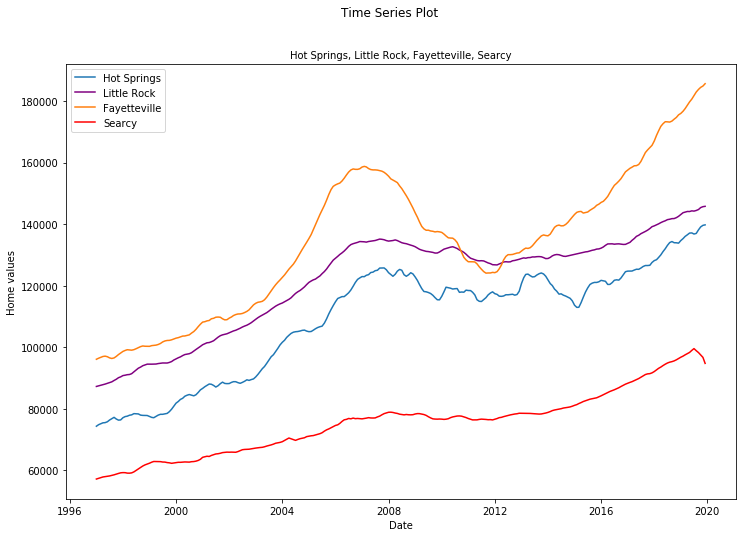

In [39]:
# Register Pandas Formatters and Converters with matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(12,8))

## Time Series Plot
plt.plot(HotSprings_ts, label='Hot Springs')
plt.plot(LittleRock_ts, label ='Little Rock', color = 'purple')
plt.plot(Fayetteville_ts, label='Fayetteville')
plt.plot(Searcy_ts, label='Searcy', color = 'red')
plt.legend()

# titles and labels
plt.suptitle('Time Series Plot')
plt.title('Hot Springs, Little Rock, Fayetteville, Searcy', fontsize=10)
plt.ylabel('Home values')
plt.xlabel('Date')

# show overall plot
plt.show();

# Models

#### The Naive Model - Baseline Model
An AR model for general time series data is going to be built as a benchmark standard



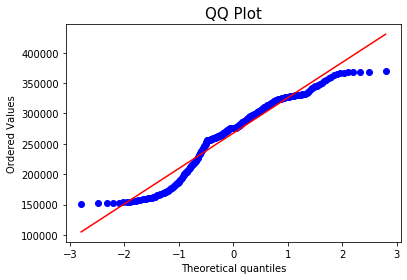

In [68]:
# Check if the time series follow the normal distribution
scipy.stats.probplot(df_gen_ts.Price, plot=pylab)
plt.title("QQ Plot", size = 15)
pylab.show()

From the QQplot above, we can observe that the general time series is not following normal distribution

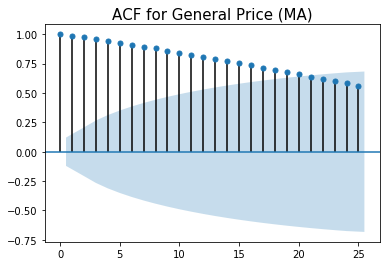

In [41]:
# ACF plot
plot_acf(df_gen_ts);
plt.title('ACF for General Price (MA)', size =15)
plt.show()

We can see the effects deteriorate slowly. 

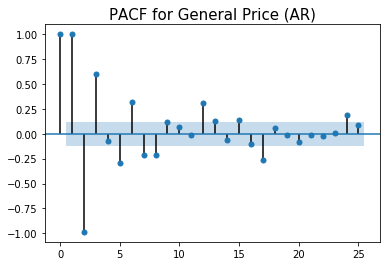

In [42]:
# PACF plot
plot_pacf(df_gen_ts, method='ols');
plt.title('PACF for General Price (AR)', size=15)
plt.show()

We can clearly see that the lag 1,2,3 are significant. This general time series can be used for AR model.

In [43]:
# Check the stationarity
adf_test = adfuller(df_gen_ts.Price) #squeeze to get rid of 1 dimension
print('\nADF Statistic: {:.6f}'.format(adf_test[0]) )
print('p-value: {:.6f}'.format(adf_test[1]))
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t{:>3s}: {:.3f}'.format(key, value))   

if adf_test[1] <= 0.05:
    print("\n** Reject the null hypothesis. Data has no unit root and is stationary **")
else:
    print("\n** Fail to reject the null hypothesis. Data has unit root and is non-stationary **")


ADF Statistic: -2.086293
p-value: 0.250062
Critical Values:
	 1%: -3.457
	 5%: -2.873
	10%: -2.573

** Fail to reject the null hypothesis. Data has unit root and is non-stationary **


From the Augmented Dickey-Fuller unit root test, we can see that the genral time series data is not stationary.    
AR model does not work vary well on non-stataionary time series.   
Thus, we can infer in advanced that the AR model will not be our best model.  
Since we only use AR model as our baseline moedel, we are targeting the model has performing better than AR model, having lower RMSE.

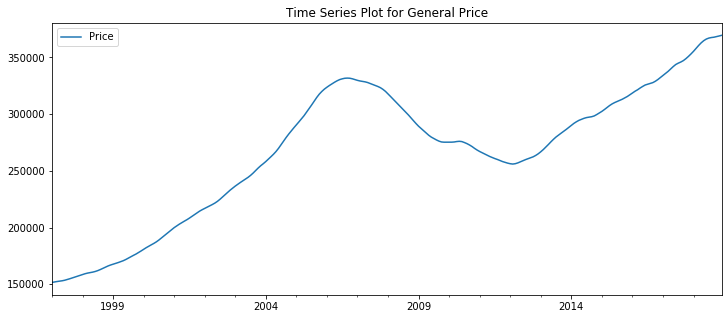

In [44]:
df_gen_ts.plot(figsize=(12,5), title='Time Series Plot for General Price');
plt.show()

In [45]:
shift_1=df_gen_ts.shift(1)
AR_df=pd.concat([df_gen_ts,shift_1], axis=1)
AR_df=AR_df[1:]
AR_df.columns=['Actual_Price','Forecaset_Price']
mse = mean_squared_error(AR_df.Actual_Price,AR_df.Forecaset_Price)
rmse=sqrt(mse)
print('The baseline RMSE: {:.3f}'.format(rmse))

The baseline RMSE: 1587.984


As a baseline model, we are looking for the model with the RMSE is lower than **1587.984** as our optimal model.

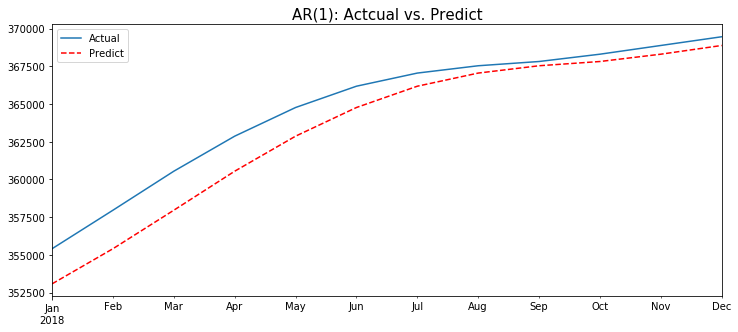

In [76]:
AR_df.Actual_Price[1:]['2018'].plot(figsize=(12,5), label='Actual');
AR_df.Forecaset_Price['2018'].plot(figsize=(12,5), label='Predict', color='red', style='--');
plt.title('AR(1): Actcual vs. Predict', size=15)
plt.legend()
plt.show()

##### Define an automation test function:

In [0]:
# Automation of Testing
def adf_test(timeseries_df):
    '''
    Expect: a time series dataframe with single column
    Modifies: no modification on the this functions
    Returns: 1. Plots: time series plot, histogram of time series, boxplot of time series, Probability plot of time series
             2. Statistics: mean and median
             3. Augmented Dickey-Fuller unit root test result    
    '''

    from statsmodels.tsa.stattools import adfuller
    import scipy.stats
    import pylab
    import pandas as pd
    import matplotlib.pyplot as plt

    print('\tZipcode: {}\n'.format(timeseries_df.columns[0]))

    # Plotting
    timeseries_df.plot(title='Time Series Plot', figsize=(8,5));
    plt.show()
    timeseries_df.hist(figsize=(8,5));
    plt.title('Histogram')
    plt.show()
    timeseries_df.boxplot(flierprops= {'marker':'D', 'markerfacecolor':'g'}, figsize=(8,5), vert=False); 
    plt.title('Box Plot')
    plt.show()
    scipy.stats.probplot(timeseries_df.squeeze(), plot=pylab); #squeeze to get rid of 1 dimension
    plt.title("QQ Plot", size = 12)
    pylab.show()

    # Statistics
    print('Central of tendency:')
    print('{:10}: {}'.format('Mean', timeseries_df.mean()[0]))
    print('{:10}: {}'.format('Median', timeseries_df.median()[0]))
    
    # Augmented Dickey-Fuller unit root test
    adf_test = adfuller(pd.Series(timeseries_df.squeeze())) #squeeze to get rid of 1 dimension
    print('\nADF Statistic: {:.6f}'.format(adf_test[0]) )
    print('p-value: {:.6f}'.format(adf_test[1]))
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t{:>3s}: {:.3f}'.format(key, value))   

    if adf_test[1] <= 0.05:
        print("\n** Reject the null hypothesis. Data has no unit root and is stationary **")
    else:
        print("\n** Fail to reject the null hypothesis. Data has unit root and is non-stationary **")

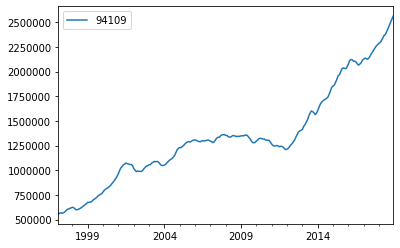

In [48]:
##
df_ts[['94109']].shift(1)[1:].plot()

	Zipcode: 94109



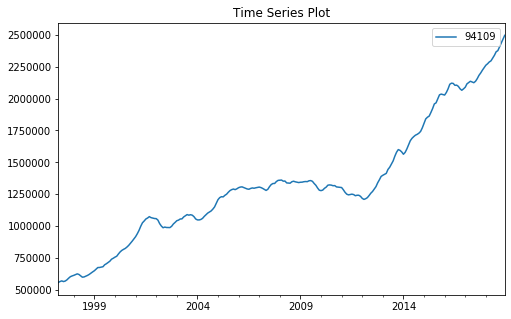

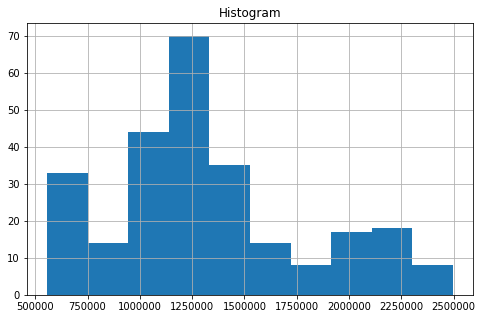

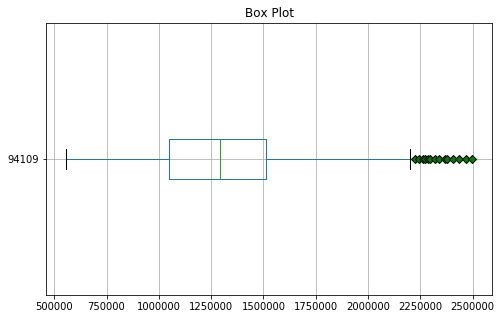

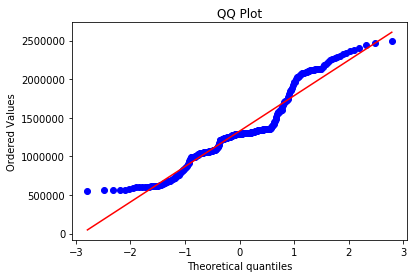

Central of tendency:
Mean      : 1327166.295019157
Median    : 1290830.0

ADF Statistic: 0.956017
p-value: 0.993780
Critical Values:
	 1%: -3.457
	 5%: -2.873
	10%: -2.573

** Fail to reject the null hypothesis. Data has unit root and is non-stationary **


In [74]:
##
adf_test(df_ts[['94109']].shift(3)[3:])

#### ARIMA Model Part 1
A general model (df_gen_ts) that is going to be built to compare the models for each zip code

To build a model, first, we use 1997-2017 as training set and 2018 as testing set.

In [50]:
train = df_gen_ts['1997':'2017']
print('Train shape: {}'.format(train.shape))
test = df_gen_ts['2018']
print('Train shape: {}'.format(test.shape))
start_date = '2018-01-01'
end_date = '2018-12-01'

Train shape: (252, 1)
Train shape: (12, 1)


In [51]:
# Build parameters for grid search
import itertools
p_values=range(0,9)
d_values=range(0,3)
q_values=range(0,5)
pdq=list(itertools.product(p_values,d_values,q_values))
len(pdq)

135

In [52]:
import warnings
warnings.filterwarnings('ignore')
best_score=None
for parameter in pdq:
    try:
        model_arima = ARIMA(train, order=parameter)
        model_arima_fit=model_arima.fit(disp=0)
        predictions = model_arima_fit.forecast(steps=len(test))[0]
#        predictions = model_arima_fit.predict(start= start_date, end= end_date) # store only the predictions
        mse=mean_squared_error(test, predictions)
        from math import sqrt
        rmse = sqrt(mse)
        print('ARIMA{}, RMSE={}'.format(parameter,round(rmse,4)))
    except:
        continue

ARIMA(0, 0, 0), RMSE=101759.8846
ARIMA(0, 0, 1), RMSE=98852.8613
ARIMA(0, 0, 3), RMSE=109783.1595
ARIMA(0, 1, 0), RMSE=6743.8482
ARIMA(0, 1, 1), RMSE=5731.4447
ARIMA(0, 2, 0), RMSE=4784.1846
ARIMA(0, 2, 1), RMSE=5114.3011
ARIMA(0, 2, 2), RMSE=6531.3487
ARIMA(0, 2, 3), RMSE=6284.79
ARIMA(1, 0, 0), RMSE=12432.079
ARIMA(1, 1, 0), RMSE=3994.0571
ARIMA(1, 1, 1), RMSE=4087.2831
ARIMA(1, 1, 2), RMSE=4465.427
ARIMA(1, 1, 3), RMSE=4486.0454
ARIMA(1, 1, 4), RMSE=4636.7856
ARIMA(1, 2, 0), RMSE=6207.7464
ARIMA(1, 2, 1), RMSE=6048.4318
ARIMA(1, 2, 2), RMSE=6361.3547
ARIMA(1, 2, 3), RMSE=6191.0137
ARIMA(1, 2, 4), RMSE=5398.2645
ARIMA(2, 0, 0), RMSE=2388.4243
ARIMA(2, 0, 1), RMSE=2462.1277
ARIMA(2, 0, 2), RMSE=3711.7515
ARIMA(2, 0, 3), RMSE=3779.7103
ARIMA(2, 0, 4), RMSE=3766.2287
ARIMA(2, 1, 0), RMSE=4270.1946
ARIMA(2, 1, 1), RMSE=4205.386
ARIMA(2, 1, 2), RMSE=4653.1433
ARIMA(2, 1, 3), RMSE=5536.3679
ARIMA(2, 1, 4), RMSE=5304.9112
ARIMA(2, 2, 0), RMSE=5834.4435
ARIMA(2, 2, 1), RMSE=4822.2435
ARIMA(2

In [0]:
# Build a Automation of ARIMA validation for the following models
def ARIMA_validation(AR, I, MA, training_set, test_set):
    '''
    Expect: p(AR),d(I),q(MA), training_set, test_set
    Modifies: N/A
    Returns: 1. ACF plot            
             2. PACF plot
             3. RMSE
             4. Line plot for Actcual vs. Predicted
             5. Model summary
             6. Line Plot of the Residual Errors
             7. Density Plot of the Residual Errors
             8. Residual Errors Statistics
    '''

    from statsmodels.tsa.arima_model import ARIMA
    from statsmodels.graphics.tsaplots import plot_acf
    from statsmodels.graphics.tsaplots import plot_pacf
    import numpy as np
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    import pandas as pd
    import matplotlib.pyplot as plt

    arima_order = (AR,I,MA)
    print('ARIMA{}\n'.format(arima_order))

    # ACF plot
    plot_acf(training_set);
    plt.title('ACF for General Price (MA)', size =15)
    plt.show()

    # PACF plot
    plot_pacf(training_set, method='ols');
    plt.title('PACF for General Price (AR)', size=15)
    plt.show()

    # ARIMA model
    model_arima = ARIMA(training_set, order=arima_order)
    model_arima_fit=model_arima.fit(disp=0)
    #predictions = model_arima_fit.forecast(steps=len(test))[0]
    predictions = model_arima_fit.predict(start= start_date, end = end_date)

    # RMSE
    mse=mean_squared_error(test_set, predictions)
    rmse = sqrt(mse)
    print('{:5}: {}'.format('RMSE', round(rmse,4)))

    # Plotting
    test_set.plot(figsize=(12,5), label='Actual');
    predictions.plot(figsize=(12,5), label='Predict', color='red', style='--');
    plt.title('Actcual vs. Predicted', size=15)
    plt.legend()
    plt.show()

    # Summary
    print(model_arima_fit.summary())

    # Residual 
    model_arima_fit.resid.plot(title='Line Plot of the Residual Errors')
    plt.show()
    model_arima_fit.resid.plot(kind='kde', title='Density Plot of the Residual Errors')
    plt.show()
    print('Residual Errors Statistics:') 
    print(model_arima_fit.resid.describe()) 

ARIMA(5, 0, 4)



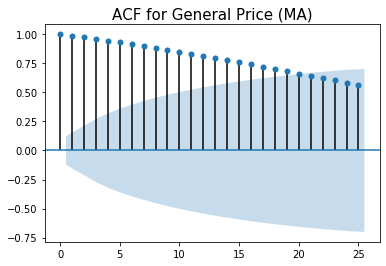

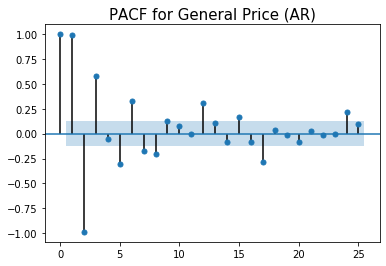

RMSE : 1391.8805


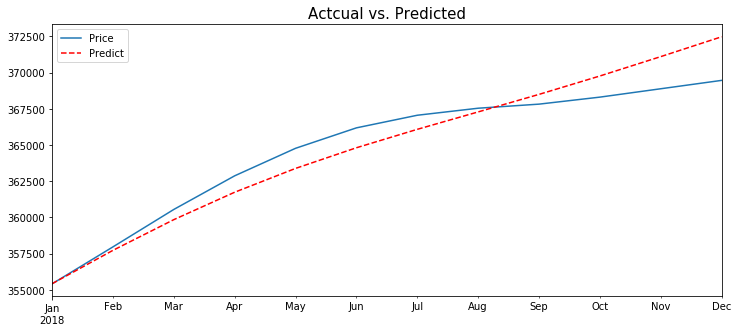

                              ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                  252
Model:                     ARMA(5, 4)   Log Likelihood               -1588.638
Method:                       css-mle   S.D. of innovations            125.090
Date:                Mon, 10 Feb 2020   AIC                           3199.277
Time:                        14:46:27   BIC                           3238.101
Sample:                    01-01-1997   HQIC                          3214.899
                         - 12-01-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.631e+05   2.86e+04      9.212      0.000    2.07e+05    3.19e+05
ar.L1.Price     3.4740      0.000   2.88e+04      0.000       3.474       3.474
ar.L2.Price    -4.5629      0.000  -3.34e+04    

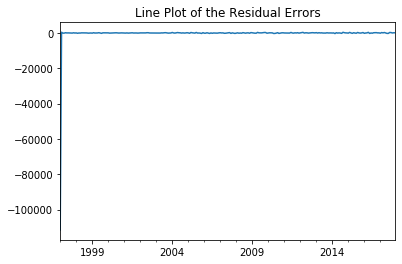

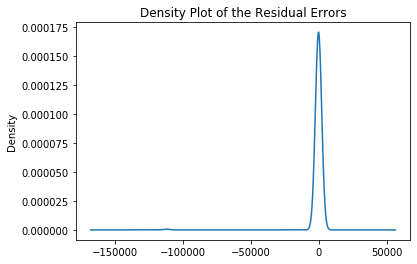

Residual Errors Statistics:
count       252.000000
mean       -432.964001
std        7025.632943
min     -111500.376960
25%         -66.172004
50%           1.750558
75%          78.493686
max         401.913128
dtype: float64


In [54]:
# prediction
ARIMA_validation(5,0,4, train, test)

#### ARIMA Model Part 2
ARIMA models (df_ts) that is going to be built for each zipcode.  
Use the order from the general time series.  

To build a model, first, we use 1997-2017 as training set and 2018 as testing set.

In [55]:
train = df_ts['1997':'2017']
print('Train shape: {}'.format(train.shape))
test = df_ts['2018']
print('Test shape: {}'.format(test.shape))
start_date = '2018-01-01'
end_date = '2018-12-01'

Train shape: (252, 7425)
Train shape: (12, 7425)


In [56]:
zipcode=[]
RMSE=[]
for i, z in enumerate(tuple(df_ts.columns), start = 1):
    try:
        zip_train = train.loc[:,z]
        zip_test = test.loc[:,z]
        # ARIMA model
        model_arima = ARIMA(zip_train, order=(5,0,4))
        model_arima_fit=model_arima.fit(disp=0)
        #predictions = model_arima_fit.forecast(steps=len(test))[0]
        predictions = model_arima_fit.predict(start= start_date, end = end_date)

        # RMSE
        mse=mean_squared_error(zip_test, predictions)
        rmse = sqrt(mse)
        zipcode.append(z)
        RMSE.append(rmse)
        print('{}. Zipcode:{}, RMSE={}'.format(i, z,round(rmse,4)))
    except:
        continue

1. Zipcode:78660, RMSE=743.1136
4. Zipcode:11375, RMSE=47247.0709
6. Zipcode:28269, RMSE=3273.2212
9. Zipcode:37042, RMSE=3901.2117
10. Zipcode:73099, RMSE=2544.2348
12. Zipcode:30044, RMSE=7197.8915
13. Zipcode:63376, RMSE=4297.0006
14. Zipcode:28277, RMSE=1776.1088
15. Zipcode:30043, RMSE=10444.8245
16. Zipcode:10463, RMSE=11009.7528
17. Zipcode:30096, RMSE=9343.8989
18. Zipcode:07030, RMSE=53258.6334
19. Zipcode:98052, RMSE=31262.6921
20. Zipcode:30024, RMSE=7510.6571
23. Zipcode:33160, RMSE=11059.5165
24. Zipcode:23464, RMSE=4097.7757
25. Zipcode:34787, RMSE=5901.4985
27. Zipcode:28027, RMSE=6350.3429
29. Zipcode:02169, RMSE=13397.6294
30. Zipcode:33411, RMSE=4281.1255
31. Zipcode:78745, RMSE=1673.8016
32. Zipcode:94110, RMSE=110614.2314
33. Zipcode:23462, RMSE=942.3576
34. Zipcode:33025, RMSE=8920.3662
37. Zipcode:33139, RMSE=18211.6835
38. Zipcode:95630, RMSE=3023.0398
39. Zipcode:48197, RMSE=8144.6045
40. Zipcode:11377, RMSE=11542.006
41. Zipcode:07302, RMSE=36961.1138
42. Zipco

In [57]:
zip_models = pd.DataFrame({'ZipCode':zipcode,'RMSE': RMSE})
zip_models.sort_values("RMSE", axis = 0, ascending = True, 
                 inplace = True)
zip_models.to_csv('df_zip_models.csv', index=False)
zip_models.shape

(5748, 2)

In [77]:
zip_models.head()

,ZipCode,RMSE
3412,72958,113.731601
5400,50435,157.302390
4220,73772,169.254759
5069,81047,186.252293
3257,81052,200.654403


In [0]:
# zip_models = pd.read_csv('/content/drive/My Drive/df_zip_models.csv')

In [59]:
zip_models=zip_models.astype({'ZipCode':str}) 
zip_models['ZipCode']=zip_models['ZipCode'].apply(normalize_zipcode)
print('Zipcode normalization has been completed')

Zipcode normalization has been completed


According to the general time series model, we got order(p,d,q)=(5,0,4) as our best model. Thus, we are going to use order(p,d,q)=(5,0,4) to perform the ARIMA models for each zip code and use the RMSE as a standard to find the top three zip codes.

# Final Model

Combine the candadate dataframe with RMSE at the order of (5,0,4) that was concluded as standard from the general time series.   
Then, we can do order by on size rank, unemployement rate and RMSE with the filter of RMSE < 1500 to find the top zip codes for investment.

In [60]:
# merge the merged_left df with zip_models
merged_final = pd.merge(left=merged_left,right=zip_models, 
                         left_on=['RegionName'], 
                         right_on=['ZipCode'],
                         how='inner')

# What's the size of the output data? It should have 5748 records
merged_final.shape

(5748, 297)

In [61]:
df_rmse = merged_final.loc[:,['ZipCode', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'Rate', 'RMSE']]
df_rmse.sort_values(by=['SizeRank', 'Rate', 'RMSE'], axis=0, ascending=True, inplace=True)
df_rmse[df_rmse['RMSE'] < 1500].head()

,ZipCode,City,State,Metro,CountyName,SizeRank,Rate,RMSE
0,78660,Pflugerville,TX,Austin-Round Rock,travis county,13,2.8,743.113608
22,23462,Virginia Beach,VA,Virginia Beach-Norfolk-Newport News,virginia beach city,95,2.9,942.357558
31,78641,Leander,TX,Austin-Round Rock,williamson county,124,3.1,1400.295816
37,97229,Portland,OR,Portland-Vancouver-Hillsboro,multnomah county,143,3.7,1493.099623
51,28078,Huntersville,NC,Charlotte-Concord-Gastonia,mecklenburg county,185,3.7,1039.944476


In [62]:
train = df_ts['1997':'2017']
print('Train shape: {}'.format(train.shape))
test = df_ts['2018']
print('Test shape: {}'.format(test.shape))
start_date = '2018-01-01'
end_date = '2018-12-01'

Train shape: (252, 7425)
Train shape: (12, 7425)


ARIMA(2, 0, 4)



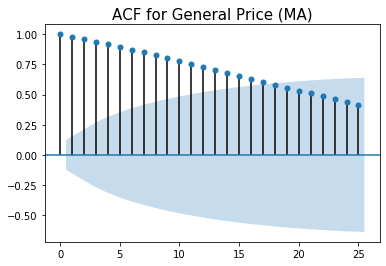

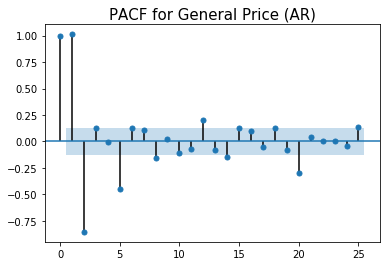

RMSE : 726.5509


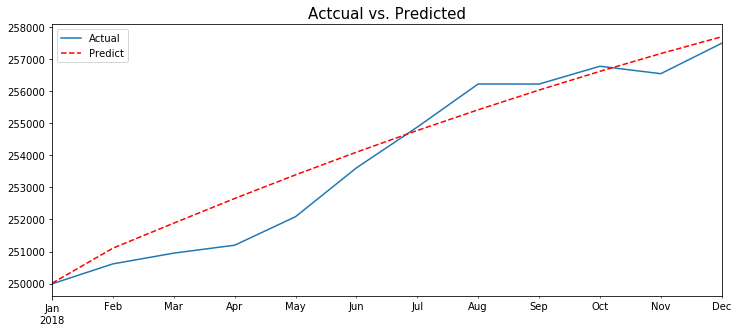

                              ARMA Model Results                              
Dep. Variable:                  78660   No. Observations:                  252
Model:                     ARMA(2, 4)   Log Likelihood               -1790.166
Method:                       css-mle   S.D. of innovations            283.017
Date:                Mon, 10 Feb 2020   AIC                           3596.332
Time:                        19:19:28   BIC                           3624.567
Sample:                    01-01-1997   HQIC                          3607.693
                         - 12-01-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         1.77e+05   2.79e+04      6.335      0.000    1.22e+05    2.32e+05
ar.L1.78660     1.9900      0.006    323.193      0.000       1.978       2.002
ar.L2.78660    -0.9903      0.006   -158.915    

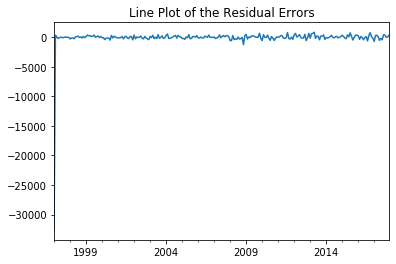

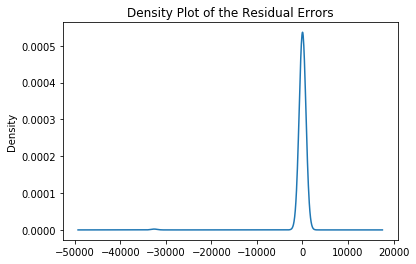

Residual Errors Statistics:
count      252.000000
mean      -114.559206
std       2073.446176
min     -32587.619041
25%       -155.637473
50%          1.654964
75%        190.827889
max        844.124650
dtype: float64


In [63]:
# Adjust the order(p,d,q)=(2,0,4)
zipcode = '78660'
train = df_ts.loc[:,zipcode]['1997':'2017']
test = df_ts.loc[:,zipcode]['2018']
ARIMA_validation(2,0,4, training_set= train, test_set=test )

ARIMA(2, 0, 1)



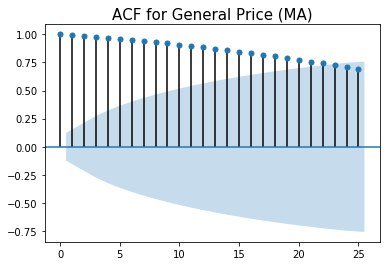

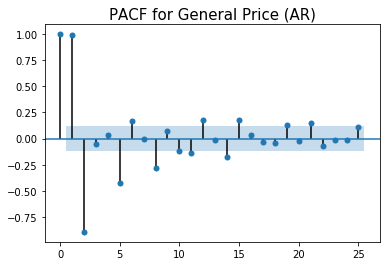

RMSE : 425.9606


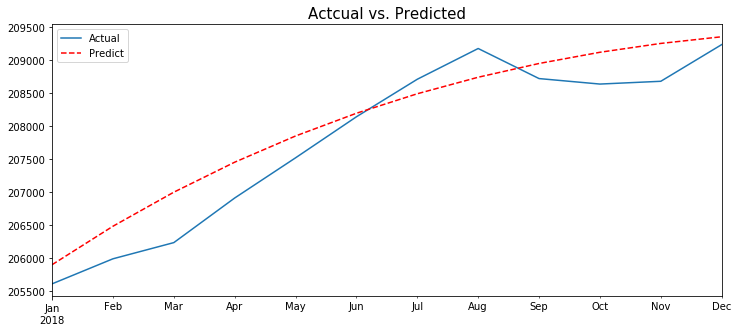

                              ARMA Model Results                              
Dep. Variable:                  23462   No. Observations:                  252
Model:                     ARMA(2, 1)   Log Likelihood               -1939.914
Method:                       css-mle   S.D. of innovations            521.768
Date:                Mon, 10 Feb 2020   AIC                           3889.827
Time:                        19:19:30   BIC                           3907.475
Sample:                    01-01-1997   HQIC                          3896.928
                         - 12-01-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.665e+05   4.04e+04      4.124      0.000    8.74e+04    2.46e+05
ar.L1.23462     1.9212      0.019    102.066      0.000       1.884       1.958
ar.L2.23462    -0.9218      0.019    -48.831    

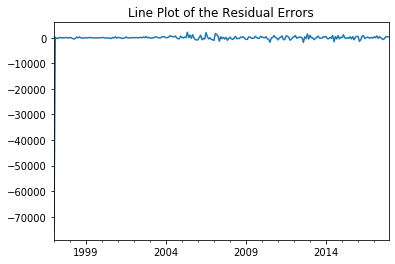

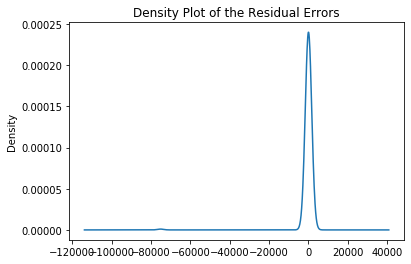

Residual Errors Statistics:
count      252.000000
mean      -257.650999
std       4766.357027
min     -75172.214344
25%       -184.248512
50%         28.420369
75%        273.097154
max       2174.490490
dtype: float64


In [64]:
# Adjust the order(p,d,q)=(2,0,1)
zipcode = '23462'
train = df_ts.loc[:,zipcode]['1997':'2017']
test = df_ts.loc[:,zipcode]['2018']
ARIMA_validation(2,0,1, training_set= train, test_set=test )

ARIMA(4, 0, 4)



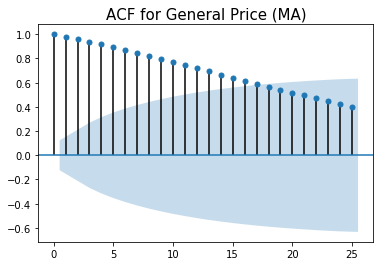

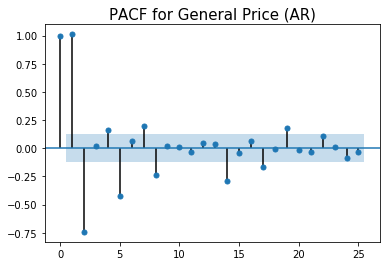

RMSE : 1513.9206


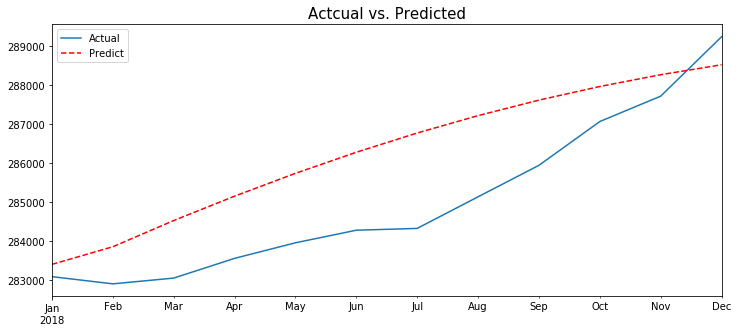

                              ARMA Model Results                              
Dep. Variable:                  78641   No. Observations:                  252
Model:                     ARMA(4, 4)   Log Likelihood               -1953.211
Method:                       css-mle   S.D. of innovations            542.889
Date:                Mon, 10 Feb 2020   AIC                           3926.423
Time:                        19:19:33   BIC                           3961.717
Sample:                    01-01-1997   HQIC                          3940.624
                         - 12-01-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.997e+05   2.55e+04      7.831      0.000     1.5e+05     2.5e+05
ar.L1.78641     2.4648      0.006    405.001      0.000       2.453       2.477
ar.L2.78641    -1.9063      0.010   -193.403    

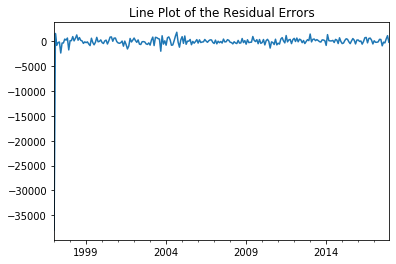

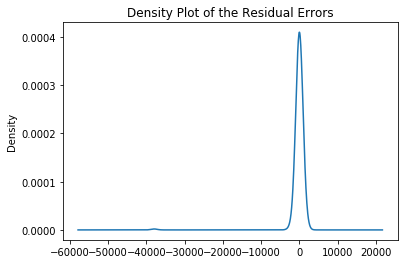

Residual Errors Statistics:
count      252.000000
mean      -123.839315
std       2458.120768
min     -37959.936936
25%       -308.877057
50%         12.164763
75%        343.504852
max       1837.341633
dtype: float64


In [65]:
# Adjust the order(p,d,q)=(2,0,4)
zipcode = '78641'
train = df_ts.loc[:,zipcode]['1997':'2017']
test = df_ts.loc[:,zipcode]['2018']
ARIMA_validation(4,0,4, test_set=test, training_set= train)

In [0]:
df_top = df_rmse[df_rmse['RMSE'] < 1500].head(3).copy()
df_top.loc[df_top.ZipCode=='78660', 'RMSE'] = 726.5509
df_top.loc[df_top.ZipCode=='23462', 'RMSE'] = 425.9606
df_top.loc[df_top.ZipCode=='78641', 'RMSE'] = 1513.9206

# Questions

**Provide an initial data analysis of the following Arkansas metro areas: Hot Springs, Little Rock, Fayetteville, Searcy** 

The time series plot shows that there are clear upward trends for each metropolitan. Fayetteville metro area has higher variation but with strong growing trend. It is a place for investor who is willing to take at higher risk with higher return of investment.  Little Rock metro area and Searcy metro area have lower variation and steady growth trends. A lower risk taker of investor can invest real estate on both areas depending on the level of capital. Hot Springs metro area might not be good choice of real estate investment for a conservative investor because of the nature of business in that area.

**What technique/algorithm/decision process did you use to down sample?**




First, I excluded the zip codes with missing data from 1997 to 2018. It had 13,916 zip codes remained. Then, I merged the unemployment information based on the county. Using the unemployment feature to exclude zip codes that have unemployment rate higher than the average unemployment rate, 3.98. After filtering out the unwanted zip codes, there were still 7,425 zip codes left as our candidates.  Then, by running the ARIMA models for each zip code with the order (p, d, q) gathered from the general time series ARIMA model, there were 5,748 as our candidates for real estate investment. 

**What three zip codes provide the best investment opportunity for the SREIT?** **Why?**

In [67]:
df_top

,ZipCode,City,State,Metro,CountyName,SizeRank,Rate,RMSE
0,78660,Pflugerville,TX,Austin-Round Rock,travis county,13,2.8,726.5509
22,23462,Virginia Beach,VA,Virginia Beach-Norfolk-Newport News,virginia beach city,95,2.9,425.9606
31,78641,Leander,TX,Austin-Round Rock,williamson county,124,3.1,1513.9206


Zip codes, 78660, 23462, 78641 are the best opportunity for the SREIT. Its' unemployment rates are way below average ,3.9, and have low RMSE (after adjusting the order of p, d, and q), indicating that the model is predicting better. Two zip codes, 78660 and 78641, are near the Austin metro area which is the place that has a diverse mix of government employees, college students, musicians, high-tech workers, blue-collar workers, and a vibrant LGBT community, also known as Silicon Hill. For the zip code, 23462, it is located between Virginia Beach and Norfolk city. Many of people may choose the place that is between the workplace and relaxing place. On top of that, having the models with low root mean square error gives the investor more room on profit. Thus, those three zip codes are the best opportunity for the SREIT.

# Conclusion

Prediction time series analysis could be time consuming. There are many need to be considered while building a model. Other Model can be implemented in the future such as SARIMAX, ARIMAX to cover the factor of seasonality, and exogenous factors. Prophet can be applied when the holiday factor is considered.